In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import numpy as np

# Motivating GMM:Weakness of K-Means

In [3]:
from sklearn.datasets import make_blobs
x,y_true=make_blobs(n_samples=400,centers=4,cluster_std=0.60,
                   random_state=0)
x=x[:,::-1] # flip axes for better plotting

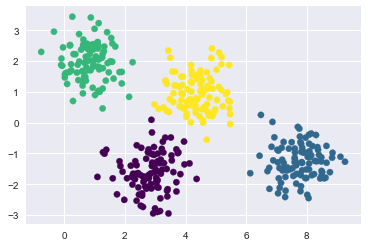

In [4]:
from sklearn.cluster import KMeans
kmeans=KMeans(4,random_state=0)
labels=kmeans.fit(x).predict(x)
plt.scatter(x[:,0],x[:,1],c=labels,s=40,cmap='viridis')

**The k-means model has no intrinsic measure of
probability or uncertainty of cluster assignments**

In [12]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans,x,n_clusters=4,rseed=0,ax=None):
    labels=kmeans.fit_predict(x)
    
    ax=plt.gca()
    ax.axis('equal')
    ax.scatter(x[:,0],x[:,1],c=labels,s=40,cmap='viridis',zorder=2)
    
    centers=kmeans.cluster_centers_
    radii=[cdist(x[labels==i],[center]).max() 
           for i,center in enumerate(centers)]
    for c,r in zip(centers,radii):
        ax.add_patch(plt.Circle(c,r,fc='#CCCCCC',lw=3,alpha=0.5,zorder=1))

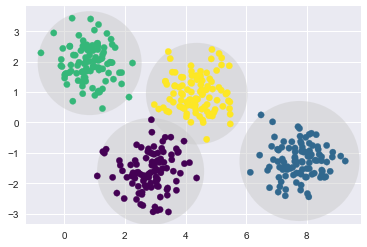

In [13]:
kmeans=KMeans(n_clusters=4,random_state=0)
plot_kmeans(kmeans,x)

**for k-means cluster models must be circular；
k-means  cannot tackle oblong or elliptical clusters**

0.0

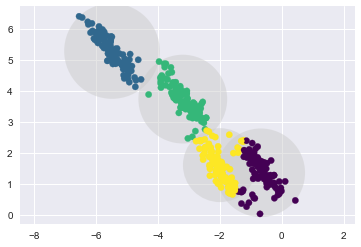

In [17]:
rng=np.random.RandomState(13)
x_streched=np.dot(x,rng.randn(2,2))

kmeans=KMeans(n_clusters=4,random_state=0)
plot_kmeans(kmeans,x_streched)


# Generalizing E–M: Gaussian Mixture Models

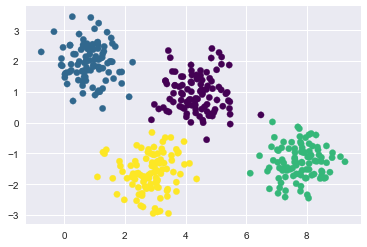

In [19]:
from sklearn.mixture import GMM
gmm=GMM(n_components=4).fit(x)
labels=gmm.predict(x)
plt.scatter(x[:,0],x[:,1],c=labels,s=40,cmap='viridis')


In [21]:
### The predict_proba method returns a matrix of size [n_samples, n_clusters] 
### which measures the probability that any point belongs to the given cluster

In [24]:
probs=gmm.predict_proba(x)
print(probs[:5].round(2))

[[0.52 0.   0.48 0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]]


In [25]:
### Visualize this uncertainty by making the size of each point 
### proportional to the certainty of its prediction

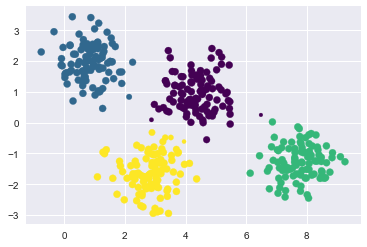

In [26]:
size=50*probs.max(1)**2 # square emphasizes differences
plt.scatter(x[:,0],x[:,1],c=labels,s=size,cmap='viridis')

## visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output

In [33]:
from matplotlib.patches import Ellipse

def draw_ellipse(position,covariance,ax=None,**kwargs):
    ax=plt.gca()
    
    if covariance.shape==(2,2):
        U,s,Vt=np.linalg.svd(covariance)
        angle=np.degrees(np.arctan2(U[1,0],U[0,0]))
        width,height=2*np.sqrt(s)
    else:
        angle=0
        width,height=2*np.sqrt(covariance)
        
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position,nsig*width,nsig*height,
                             angle,**kwargs))
        
def plot_gmm(gmm,x,label=True,ax=None):
    ax=plt.gca()
    labels=gmm.fit(x).predict(x)
    if label:
        ax.scatter(x[:,0],x[:,1],c=labels,s=40,cmap='viridis',zorder=2)
    else:
        ax.scatter(x[:,0],x[:,1],s=40,zorder=2)
        
    ax.axis('equal')
    
    w_factor=0.2/gmm.weights_.max()
    for pos,covar,w in zip(gmm.means_,gmm.covars_,gmm.weights_):
        draw_ellipse(pos,covar,alpha=w*w_factor)

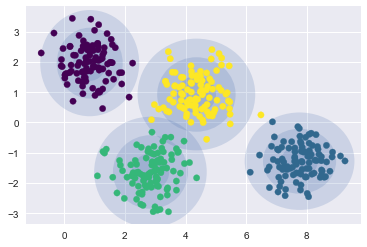

In [31]:
gmm=GMM(n_components=4,random_state=42)
plot_gmm(gmm,x)

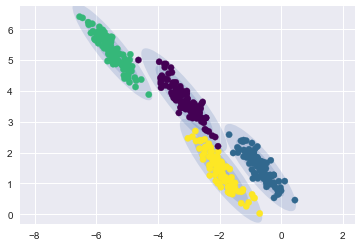

In [34]:
gmm=GMM(n_components=4,covariance_type='full',random_state=42)
plot_gmm(gmm,x_streched)

## Choosing the covariance type

**the covariance_type option  controls the degrees of freedom 
in the shape of each cluster**

# GMM as Density Estimation

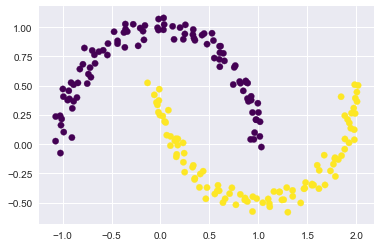

In [38]:
from sklearn.datasets import make_moons
x,y=make_moons(200,noise=0.05,random_state=0)
plt.scatter(x[:,0],x[:,1],c=y,s=40,cmap='viridis')

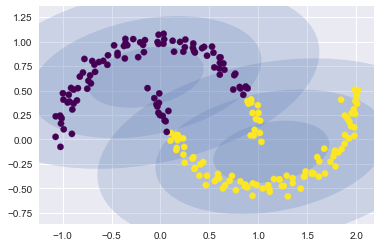

In [39]:
gmm2=GMM(n_components=2,covariance_type='full',random_state=0)
plot_gmm(gmm2,x)

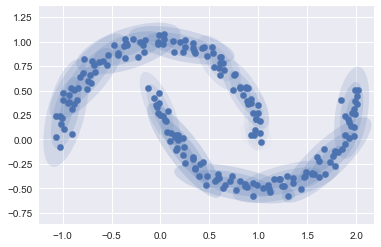

In [40]:
gmm16=GMM(n_components=16,covariance_type='full',random_state=0)
plot_gmm(gmm16,x,label=False)

**The mixture of 16 Gaussians models the overall distribution of the input data**

**400 new points drawn from this 16-component GMM fit to our original data**

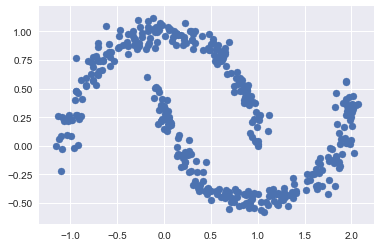

In [41]:
xnew=gmm16.sample(400,random_state=42)
plt.scatter(xnew[:,0],xnew[:,1])

## How many components?



Text(0.5,0,'n_components')

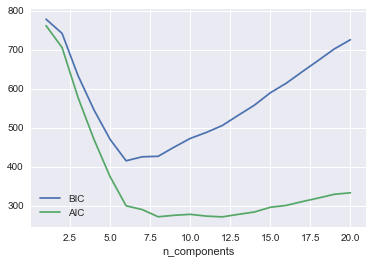

In [43]:
n_components=np.arange(1,21)
models=[GMM(n,covariance_type='full',random_state=0).fit(x) 
        for n in n_components]
plt.plot(n_components,[m.bic(x) for m in models],label='BIC')
plt.plot(n_components,[m.aic(x) for m in models],label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

**The optimal number of clusters is the value that minimizes the AIC or BIC**

**This choice of number of components measures how well GMM works as a density estimator, 
not how well it works as a clustering algorithm**

# Example: GMM for Generating New Data

In [44]:
from sklearn.datasets import load_digits
digits=load_digits()
digits.data.shape

(1797, 64)

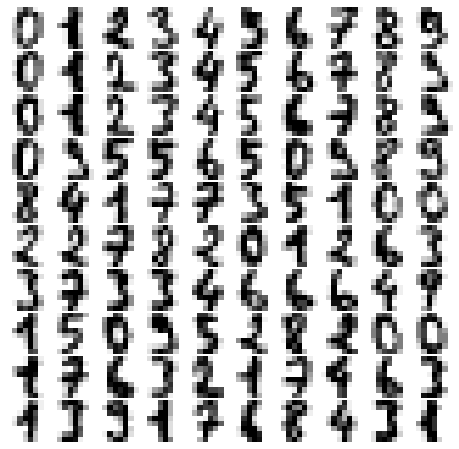

In [46]:
def plot_digits(data):
    fig,ax=plt.subplots(10,10,figsize=(8,8),
                       subplot_kw=dict(xticks=[],yticks=[]))
    
    fig.subplots_adjust(hspace=0.05,wspace=0.05)
    for i,axi in enumerate(ax.flat):
        im=axi.imshow(data[i].reshape(8,8),cmap='binary')
        im.set_clim(0,16)
        
plot_digits(digits.data)

In [47]:
from sklearn.decomposition import PCA
pca=PCA(0.99,whiten=True)
data=pca.fit_transform(digits.data)
data.shape

(1797, 41)

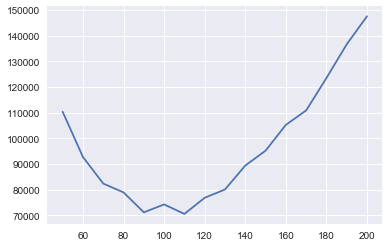

In [49]:
n_components=np.arange(50,210,10)
models=[GMM(n,covariance_type='full',random_state=0)
       for n in n_components]
acis=[model.fit(data).aic(data) for model in models]
plt.plot(n_components,acis)

In [50]:
gmm=GMM(110,covariance_type='full',random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [51]:
data_new=gmm.sample(100,random_state=0)
data_new.shape

(100, 41)

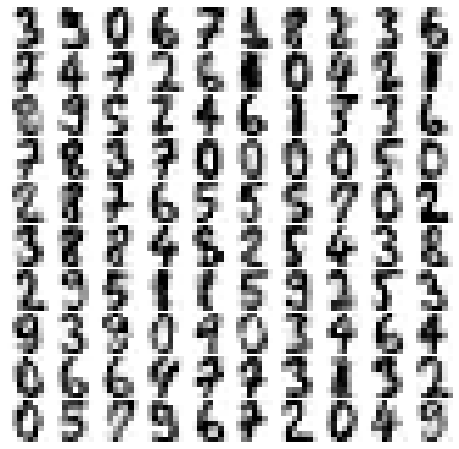

In [52]:
digits_new=pca.inverse_transform(data_new)
plot_digits(digits_new)